# 0. Initial code

In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

import tqdm

In [2]:
NUM_RUNS = 10
EPSILON = 1      # placeholder value - you should implement your own exploration schedule

In [3]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([4,2])
    target_net = DQN([4,2])
    update_target(target_net, policy_net)
        
    target_net.eval()
    
    optimizer = optim.SGD(policy_net.parameters(), lr=0.02) # HYPERPARAMS : SGD and lr
    memory = ReplayBuffer(1) # HYPERPARAM : Buffer size

    steps_done = 0

    episode_durations = []

    for i_episode in range(300):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 300)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state) # HYPERPARAM : Epsilon

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < 1: # HYPERPARAM : 1 = Batch size
                transitions = memory.sample(1)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % 1 == 0: 
            #print(policy_net)
            update_target(target_net, policy_net)
            #print(policy_net)
    runs_results.append(episode_durations)
print('Complete')

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

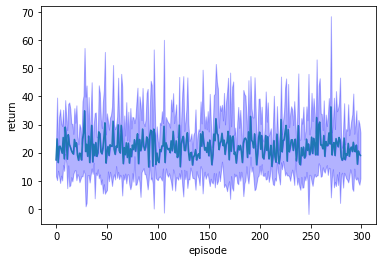

In [4]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(300), means)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

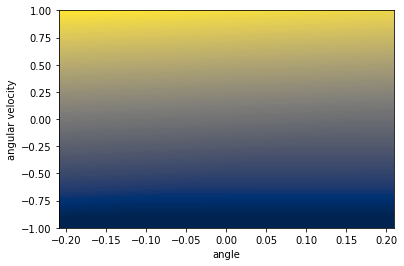

In [5]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()

# 1. Importing libraries

In [6]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

import tqdm

# 2. Defining class and functions to simulate the agent

In [7]:
class Simulation():
    
    def __init__(self, env = gym.make('CartPole-v1'), nb_episodes = 300, DQN_dimensions = [4,2], eps = 1., lr = 0.02, batch_size = 1, buffer_size = 1):
        
        #print(eps)
        self.env = env
        self.nb_episodes = nb_episodes
        self.DQN_dimensions = DQN_dimensions
        self.eps = eps
        self.lr = lr
        self.batch_size = batch_size
        self.buffer_size = buffer_size
                
        return
    
    def plot_learning_curve(self, sim_results):
        
        results = torch.tensor(sim_results)
        means = results.float().mean(0)
        stds = results.float().std(0)
        
        plt.figure(figsize = (14,8))
        plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')
        plt.plot(torch.arange(nb_episodes), means, label = f'Averaged mean')
        plt.fill_between(np.arange(nb_episodes), means+stds, means-stds, alpha=0.3, color='orange', label = f'Averaged std')
        plt.title(f"Learning curve of the DQN agent with {len(sim_results)} replications, {self.nb_episodes} episodes and the following neural network : {self.DQN_dimensions} \n The agent uses $\epsilon$ = {self.eps}, lr = {self.lr}, batch size = {self.batch_size}, buffer size = {self.buffer_size}", fontsize = 14)        
        plt.ylabel("Return", fontsize = 17)
        plt.xlabel("Number of episodes", fontsize = 17)
        plt.legend(loc = 'lower right', fontsize = 14)
        plt.show()
        
        return
    
    def display_maps(self, policy_net):
        
        #policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
        q = True    # whether q values or greedy policy is visualised

        angle_range = .2095 # you may modify this range
        omega_range = 1     # you may modify this range

        angle_samples = 100
        omega_samples = 100
        angles = torch.linspace(angle_range, -angle_range, angle_samples)
        omegas = torch.linspace(-omega_range, omega_range, omega_samples)

        greedy_q_array = torch.zeros((angle_samples, omega_samples))
        policy_array = torch.zeros((angle_samples, omega_samples))
        for i, angle in enumerate(angles):
            for j, omega in enumerate(omegas):
                state = torch.tensor([0., 0., angle, omega])
                with torch.no_grad():
                    q_vals = policy_net(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, j] = q_vals[greedy_action]
                    policy_array[i, j] = greedy_action
        if q:
            plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        else:
            plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        plt.xlabel("Angle")
        plt.ylabel("Angular velocity")
        plt.show()

        return    
    
    def generate_an_episode(self, env, eps, policy_net, memory, batch_size, target_net, optimizer):
                                                        
        observation, info = self.env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
                
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(eps, policy_net, state)

            observation, reward, done, terminated, info = self.env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size: # HYPERPARAM : 1 = Batch size
                
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations = t + 1
                
            t += 1
            
        # Update the target network, copying all weights and biases in DQN
        update_target(target_net, policy_net)  
        
        return episode_durations, policy_net, target_net
    
    def genererate_all_episodes(self, nb_episodes, policy_net, memory, target_net, optimizer):
        
        all_durations = []       
        
        for episode in tqdm.tqdm(range(nb_episodes)):
            
            ep_duration, policy_net, target_net = self.generate_an_episode(env, eps, policy_net, memory, batch_size, target_net, optimizer)
            all_durations.append(ep_duration)
            
        return all_durations
    
    def generate_replications(self, nb_replications):
        
        all_results = []
        
        for replicate in range(nb_replications):
            
            print(f"Starting replication {replicate+1} of {nb_replications}")
            policy_net = DQN(self.DQN_dimensions)
            target_net = DQN(self.DQN_dimensions)
            update_target(target_net, policy_net)
            target_net.eval()

            #optimizer = optim.SGD(policy_net.parameters(), lr) 
            #optimizer = optim.Adam(policy_net.parameters(), lr)
            optimizer = optim.Adagrad(policy_net.parameters(), lr)
            memory = ReplayBuffer(buffer_size)
            
            all_ep_durations = self.genererate_all_episodes(nb_episodes, policy_net, memory, target_net, optimizer)
            all_results.append(all_ep_durations)
        
        return all_results, policy_net

# 3. Performing classic simulation - Random parameters

#### **Initialization of parameters and hyperparameters**

In [8]:
env = gym.make('CartPole-v1')
nb_episodes = 350
DQN_dimensions = [4, 8, 8, 2]
eps = 1.
lr = 0.07
batch_size = 256
nb_replications = 10
buffer_size = 100000

#### **Simulation of our agent's behaviour (DQN)**

In [9]:
simulation = Simulation(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
sim_results, policy_trained_DQN = simulation.generate_replications(nb_replications)

Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 91.97it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 123.79it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 112.66it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 138.10it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 141.54it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 134.55it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 48.11it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 96.36it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 106.08it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 111.41it/s]


#### **Display of the agent's learning curve**

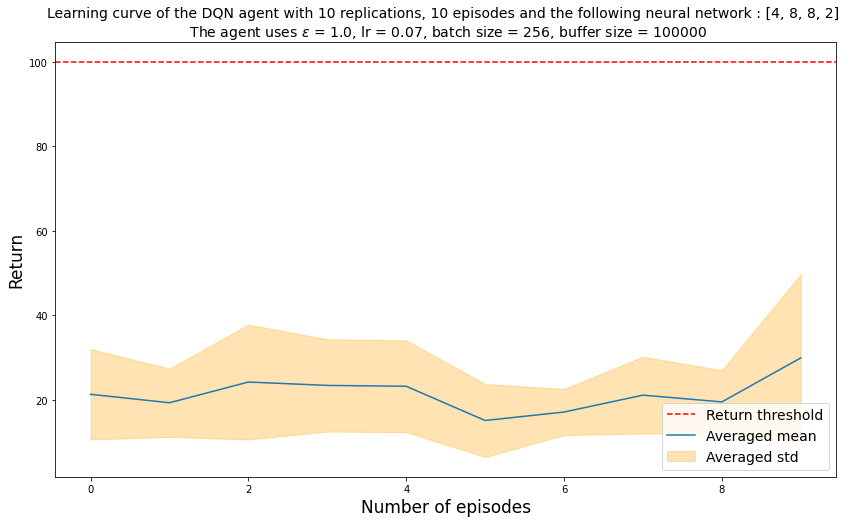

In [10]:
simulation.plot_learning_curve(sim_results)

#### **Display of the agent's map**

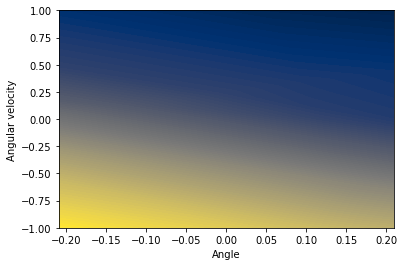

In [11]:
simulation.display_maps(policy_trained_DQN)

# 4. Decaying epsilon

## 4.1 Re-defining class and function with a decaying epsilon

In [12]:
class Simulation_Decay():
    
    def __init__(self, env = gym.make('CartPole-v1'), nb_episodes = 300, DQN_dimensions = [4,2], eps = 1., lr = 0.02, batch_size = 1, buffer_size = 1):
        
        #print(eps)
        self.env = env
        self.nb_episodes = nb_episodes
        self.DQN_dimensions = DQN_dimensions
        self.eps = eps
        self.lr = lr
        self.batch_size = batch_size
        self.buffer_size = buffer_size
                
        return
    
    def plot_learning_curve(self, sim_results):
        
        results = torch.tensor(sim_results)
        means = results.float().mean(0)
        stds = results.float().std(0)
        
        plt.figure(figsize = (14,8))
        plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')
        plt.plot(torch.arange(nb_episodes), means, label = f'Averaged mean')
        plt.fill_between(np.arange(nb_episodes), means+stds, means-stds, alpha=0.3, color='orange', label = f'Averaged std')
        plt.title(f"Learning curve of the DQN agent with {len(sim_results)} replications, {self.nb_episodes} episodes and the following neural network : {self.DQN_dimensions} \n The agent uses $\epsilon$ = {self.eps}, lr = {self.lr}, batch size = {self.batch_size}, buffer size = {self.buffer_size}, Adagrad and decay option 4", fontsize = 14)        
        plt.ylabel("Return", fontsize = 17)
        plt.xlabel("Number of episodes", fontsize = 17)
        plt.legend(loc = 'lower right', fontsize = 14)
        plt.show()
        
        return
    
    def display_maps(self, policy_net, velocity, q = True):
        
        #policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
        #q = True    # whether q values or greedy policy is visualised

        angle_range = .2095 # you may modify this range
        omega_range = 2.5     # you may modify this range

        angle_samples = 100
        omega_samples = 100
        angles = torch.linspace(angle_range, -angle_range, angle_samples)
        omegas = torch.linspace(-omega_range, omega_range, omega_samples)

        greedy_q_array = torch.zeros((angle_samples, omega_samples))
        policy_array = torch.zeros((angle_samples, omega_samples))
        for i, angle in enumerate(angles):
            for j, omega in enumerate(omegas):
                state = torch.tensor([0., velocity, angle, omega])
                with torch.no_grad():
                    q_vals = policy_net(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, j] = q_vals[greedy_action]
                    policy_array[i, j] = greedy_action
                    
        plt.figure(figsize = (12,8))
        if q:
            plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
            plt.title(f"Map of the Q values of the DQN with a cart velocity of {velocity}", fontsize = 17)
            plt.colorbar()
            
        else:
            plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
            plt.title(f"Map of the greedy policy of the DQN with a cart velocity of {velocity}", fontsize = 17)
            leg = [plt.Rectangle((0, 0), 1, 1, fc='yellow'), plt.Rectangle((0, 0), 1, 1, fc='blue')]
            plt.legend(leg, ["Apply a force on the left (push right =>)", "Apply a force on the right (push left <=)"], loc = "lower right")
        
        plt.xlabel("Angle", fontsize = 17)
        plt.ylabel("Angular velocity", fontsize = 17)
        plt.show()
        
        return
    
    def generate_an_episode(self, env, eps, policy_net, memory, batch_size, target_net, optimizer, eps_decay):
        
        #print(eps)
           
        observation, info = self.env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
                
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(eps, policy_net, state)

            observation, reward, done, terminated, info = self.env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size: # HYPERPARAM : 1 = Batch size
                
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations = t + 1
                
            t += 1
            
        # Update the target network, copying all weights and biases in DQN
        update_target(target_net, policy_net)  
        
        if eps_decay == 1:
            eps = eps * 0.99
        elif eps_decay == 2:
            eps = eps * 0.97
        elif eps_decay == 3:
            eps = eps * 0.95
        elif eps_decay == 4:
            eps = eps * 0.93
        elif eps_decay == 5:
            eps = eps * 0.9
        else :
            eps = eps * 0.85           
        
        return episode_durations, policy_net, target_net, eps
    
    def genererate_all_episodes(self, nb_episodes, policy_net, memory, target_net, optimizer, eps, eps_decay):
        
        all_durations = []  
        all_eps = []
        
        #all_eps.append(eps)
        
        for episode in tqdm.tqdm(range(nb_episodes)):
            
            all_eps.append(eps)
            ep_duration, policy_net, target_net, eps = self.generate_an_episode(env, eps, policy_net, memory, batch_size, target_net, optimizer, eps_decay)
            #print(eps)
            all_durations.append(ep_duration)
            
            
        return all_durations, all_eps
    
    def generate_replications(self, nb_replications, eps_decay):
        
        all_results = []
        all_eps_decay = []
        
        for replicate in range(nb_replications):
            
            print(f"Starting replication {replicate+1} of {nb_replications}")
            policy_net = DQN(self.DQN_dimensions)
            target_net = DQN(self.DQN_dimensions)
            update_target(target_net, policy_net)
            target_net.eval()

            #optimizer = optim.SGD(policy_net.parameters(), lr) 
            #optimizer = optim.Adam(policy_net.parameters(), lr)
            optimizer = optim.Adagrad(policy_net.parameters(), lr)
            memory = ReplayBuffer(buffer_size)
            
            all_ep_durations, all_eps_values = self.genererate_all_episodes(nb_episodes, policy_net, memory, target_net, optimizer, eps, eps_decay)
            all_results.append(all_ep_durations)
            all_eps_decay.append(all_eps_values)
        
        return all_results, policy_net, all_eps_decay

## 4.2 Performing decaying simulation - Finding optimal epsilon decay

#### **Initialization of the parameters**

In [13]:
env = gym.make('CartPole-v1')
nb_episodes = 350
DQN_dimensions = [4, 8, 8, 2]
lr = 0.07
batch_size = 256
nb_replications = 10
buffer_size = 100000
eps = 1.

eps_decay = [1, 2, 3, 4, 5, 6]
decay_results = []
means_list = []
stds_list = []

#### **Performing the simulations**

In [14]:
for decay_option in eps_decay :   
    
    print('Option :', decay_option)
    simulation = Simulation_Decay(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
    sim_results, policy_trained_DQN, eps_decay_values = simulation.generate_replications(nb_replications, decay_option)
    
    #print(np.shape(eps_decay_values))
    eps_decay_values = np.array(eps_decay_values, dtype = float)
    
    results = torch.tensor(sim_results)
    means = results.float().mean(0)
    stds = results.float().std(0)
    means_list.append(means)
    stds_list.append(stds)
    
    eps_mean = eps_decay_values.mean(0)
    decay_results.append(eps_mean)

Option : 1
Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 115.96it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 107.28it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 149.42it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 130.22it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 106.96it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 131.88it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 47.90it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 99.28it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 117.39it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 123.34it/s]


Option : 2
Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 131.93it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 169.95it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 66.40it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 90.26it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 130.22it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 213.61it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 145.92it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 123.86it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 126.92it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 154.25it/s]


Option : 3
Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 130.62it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 131.93it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 103.31it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 99.83it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 93.71it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 106.67it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 151.03it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 144.04it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 123.07it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 181.12it/s]


Option : 4
Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 135.44it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 262.50it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 150.31it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 199.98it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 203.76it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 200.27it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 149.87it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 150.02it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 141.64it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 186.09it/s]


Option : 5
Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 259.43it/s]

Starting replication 2 of 10



100%|██████████| 10/10 [00:00<00:00, 195.94it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 150.65it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 263.85it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 229.72it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 210.21it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 199.83it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 200.31it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 147.43it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 200.51it/s]


Option : 6
Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 233.18it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 108.82it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 194.02it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 176.61it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 257.09it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 244.35it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 190.38it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 181.85it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 189.77it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 201.84it/s]


#### **Displaying the results**

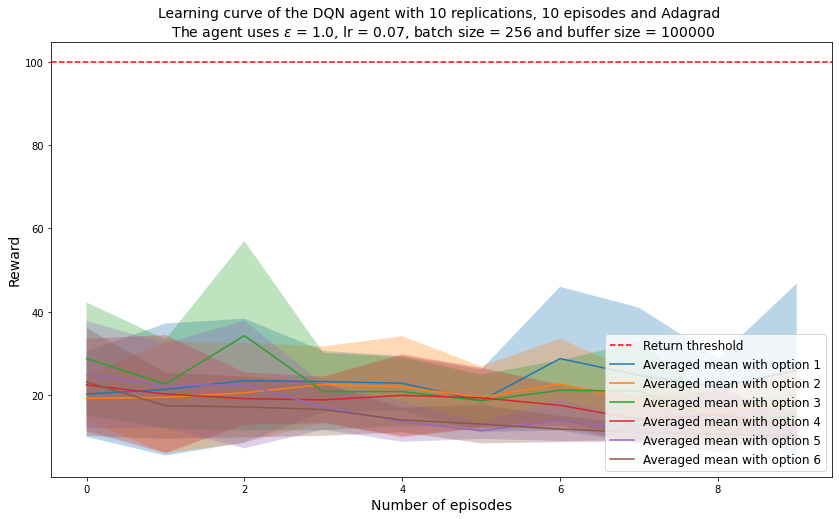

In [15]:
plt.figure(figsize = (14,8))
plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')

for i, decay_option in enumerate(eps_decay):
    
    plt.plot(torch.arange(nb_episodes), means_list[i], label = f'Averaged mean with option {decay_option}')
    plt.fill_between(np.arange(nb_episodes), means_list[i]+stds_list[i], means_list[i]-stds_list[i], alpha=0.3)
    plt.title(f"Learning curve of the DQN agent with {len(sim_results)} replications, {nb_episodes} episodes and Adagrad \n The agent uses $\epsilon$ = {eps}, lr = {lr}, batch size = {batch_size} and buffer size = {buffer_size}", fontsize = 14)        
    plt.ylabel("Reward", fontsize = 14)
    plt.xlabel("Number of episodes", fontsize = 14)
    plt.legend(loc = 'lower right', fontsize = 12)
    
plt.show()

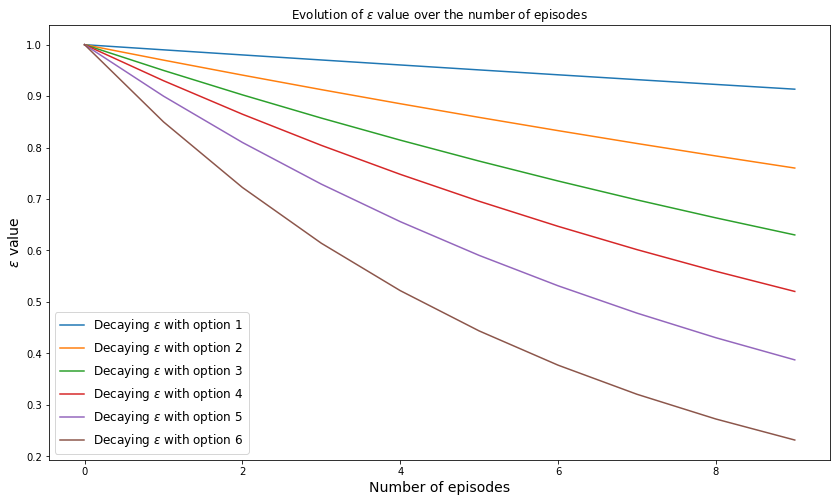

In [16]:
plt.figure(figsize = (14,8))

for i, decay_option in enumerate(eps_decay):
    
    plt.plot(torch.arange(nb_episodes), decay_results[i], label = f"Decaying $\epsilon$ with option {decay_option}")
    plt.title(f"Evolution of $\epsilon$ value over the number of episodes")        
    plt.ylabel("$\epsilon$ value", fontsize = 14)
    plt.xlabel("Number of episodes", fontsize = 14)
    plt.legend(loc = 'best', fontsize = 12)
    
plt.show()

# 5. Fine-tuning

## 5.1 Varying epsilon

#### **Initialization of the parameters**

In [17]:
env = gym.make('CartPole-v1')
nb_episodes = 350
DQN_dimensions = [4, 8, 8, 2]
lr = 0.07
batch_size = 256
nb_replications = 10
buffer_size = 100000
decay_option = 4

eps_list = [0.3, 0.7, 1.]
eps_results = []
means_list = []
stds_list = []

#### **Performing the simulations**

In [18]:
for eps in eps_list :   
    
    simulation = Simulation_Decay(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
    sim_results, policy_trained_DQN, _ = simulation.generate_replications(nb_replications, decay_option)
    results = torch.tensor(sim_results)
    means = results.float().mean(0)
    stds = results.float().std(0)
    means_list.append(means)
    stds_list.append(stds)

Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 196.61it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 238.76it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 257.05it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 286.48it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 233.19it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 257.10it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 217.98it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 250.67it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 233.18it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 238.74it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 149.65it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 156.67it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 182.31it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 208.89it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 189.18it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 189.18it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 185.68it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 216.86it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 179.04it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 182.31it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 131.93it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 53.85it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 114.93it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 113.95it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 143.24it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 221.71it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 228.92it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 168.20it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 199.60it/s]

Starting replication 10 of 10



100%|██████████| 10/10 [00:00<00:00, 209.99it/s]


#### **Displaying the results**

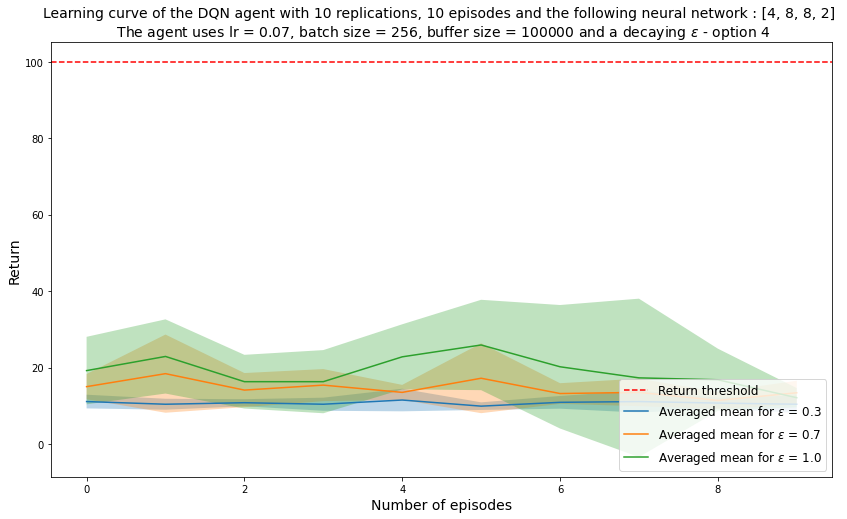

In [19]:
plt.figure(figsize = (14,8))
plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')

for i, eps in enumerate(eps_list):
    
    plt.plot(torch.arange(nb_episodes), means_list[i], label = f'Averaged mean for $\epsilon$ = {eps}')
    plt.fill_between(np.arange(nb_episodes), means_list[i]+stds_list[i], means_list[i]-stds_list[i], alpha=0.3)
    plt.title(f"Learning curve of the DQN agent with {len(sim_results)} replications, {nb_episodes} episodes and the following neural network : {DQN_dimensions} \n The agent uses lr = {lr}, batch size = {batch_size}, buffer size = {buffer_size} and a decaying $\epsilon$ - option {decay_option}", fontsize = 14)        
    plt.ylabel("Return", fontsize = 14)
    plt.xlabel("Number of episodes", fontsize = 14)
    plt.legend(loc = 'lower right', fontsize = 12)
    
plt.show()

## 5.2 Varying learning rate

#### **Initialization of the parameters**

In [20]:
env = gym.make('CartPole-v1')
nb_episodes = 350
DQN_dimensions = [4, 8, 8, 2]
eps = 1.
batch_size = 256
nb_replications = 10
buffer_size = 100000
decay_option = 4

lr_list = [0.01, 0.03, 0.07, 0.1]
lr_results = []
means_list = []
stds_list = []

#### **Performing the simulations**

In [21]:
for lr in lr_list :   
    
    simulation = Simulation_Decay(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
    sim_results, policy_trained_DQN, _ = simulation.generate_replications(nb_replications, decay_option)
    results = torch.tensor(sim_results)
    means = results.float().mean(0)
    stds = results.float().std(0)
    means_list.append(means)
    stds_list.append(stds)

Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 125.33it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 195.51it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 135.50it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 192.82it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 134.81it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 147.25it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 196.61it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 232.81it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 170.06it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 172.76it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 164.38it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 145.21it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 147.51it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 200.54it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 125.23it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 167.12it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 196.61it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 169.94it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 167.11it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 232.30it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 159.16it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 180.96it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 175.91it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 208.42it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 159.16it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 168.75it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 198.07it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 166.40it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 141.97it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 181.88it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 168.25it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 251.62it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 206.83it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 200.04it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 134.09it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 160.89it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 186.01it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 179.05it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 200.05it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 160.48it/s]


#### **Displaying the results**

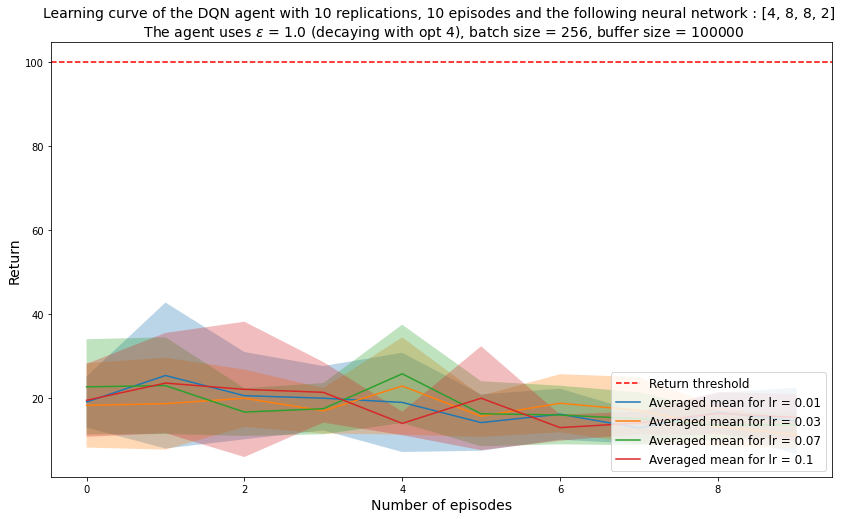

In [22]:
plt.figure(figsize = (14,8))
plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')

for i, lr in enumerate(lr_list):
    
    plt.plot(torch.arange(nb_episodes), means_list[i], label = f'Averaged mean for lr = {lr}')
    plt.fill_between(np.arange(nb_episodes), means_list[i]+stds_list[i], means_list[i]-stds_list[i], alpha=0.3)
    plt.title(f"Learning curve of the DQN agent with {len(sim_results)} replications, {nb_episodes} episodes and the following neural network : {DQN_dimensions} \n The agent uses $\epsilon$ = {eps} (decaying with opt {decay_option}), batch size = {batch_size}, buffer size = {buffer_size}", fontsize = 14)        
    plt.ylabel("Return", fontsize = 14)
    plt.xlabel("Number of episodes", fontsize = 14)
    plt.legend(loc = 'lower right', fontsize = 12)
    
plt.show()

## 5.3 Varying batch size

#### **Initialization of the parameters**

In [23]:
env = gym.make('CartPole-v1')
nb_episodes = 350
DQN_dimensions = [4, 8, 8, 2]
eps = 1.
lr = 0.07
nb_replications = 10
buffer_size = 100000
decay_option = 4

batch_list = [64, 128, 256, 512, 1024]
batch_results = []
means_list = []
stds_list = []

#### **Performing the simulations**

In [24]:
for batch_size in batch_list :   
    
    simulation = Simulation_Decay(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
    sim_results, policy_trained_DQN, _ = simulation.generate_replications(nb_replications, decay_option)
    results = torch.tensor(sim_results)
    means = results.float().mean(0)
    stds = results.float().std(0)
    means_list.append(means)
    stds_list.append(stds)

Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 28.34it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 22.02it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 23.79it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 24.68it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 10.74it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 15.13it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 16.73it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 25.33it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 25.47it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 57.04it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 17.87it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 37.57it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 33.79it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 34.88it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 26.54it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 30.75it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 25.50it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 77.34it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 46.44it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 122.28it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 128.72it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 180.39it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 132.63it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 54.00it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 113.86it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 185.72it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 146.36it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 148.94it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 155.32it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 177.50it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 196.30it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 207.97it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 150.18it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 150.37it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 204.63it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 200.54it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 195.81it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 120.65it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 230.47it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 126.93it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 202.17it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 120.66it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 143.90it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 149.45it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 139.97it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 151.92it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 213.33it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 159.16it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 200.53it/s]


#### **Displaying the results**

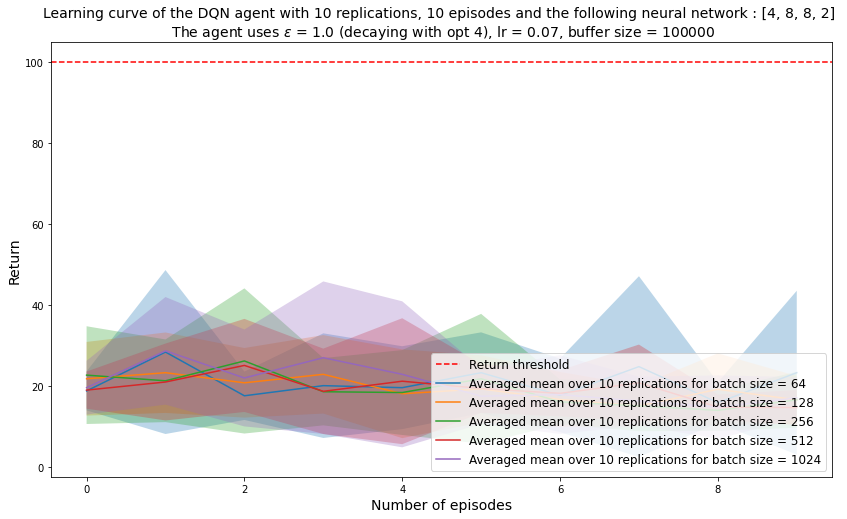

In [25]:
plt.figure(figsize = (14,8))
plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')

for i, batch in enumerate(batch_list):
    
    plt.plot(torch.arange(nb_episodes), means_list[i], label = f'Averaged mean over {len(sim_results)} replications for batch size = {batch}')
    plt.fill_between(np.arange(nb_episodes), means_list[i]+stds_list[i], means_list[i]-stds_list[i], alpha=0.3)
    plt.title(f"Learning curve of the DQN agent with {len(sim_results)} replications, {nb_episodes} episodes and the following neural network : {DQN_dimensions} \n The agent uses $\epsilon$ = {eps} (decaying with opt {decay_option}), lr = {lr}, buffer size = {buffer_size}", fontsize = 14)        
    plt.ylabel("Return", fontsize = 14)
    plt.xlabel("Number of episodes", fontsize = 14)
    plt.legend(loc = 'lower right', fontsize = 12)
    
plt.show()

## 5.4 Varying buffer size (memory)

#### **Initialization of the parameters**

In [26]:
env = gym.make('CartPole-v1')
nb_episodes = 350
DQN_dimensions = [4, 8, 8, 2]
eps = 1.
lr = 0.07
batch_size = 256
nb_replications = 10
decay_option = 4

buffer_list = [5000, 10000, 25000, 50000, 100000]
buffer_results = []
means_list = []
stds_list = []

#### **Performing the simulations**

In [27]:
for buffer_size in buffer_list :   
    
    simulation = Simulation_Decay(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
    sim_results, policy_trained_DQN, _ = simulation.generate_replications(nb_replications, decay_option)
    results = torch.tensor(sim_results)
    means = results.float().mean(0)
    stds = results.float().std(0)
    means_list.append(means)
    stds_list.append(stds)

Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 117.97it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 179.99it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 122.28it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 161.72it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 69.17it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 131.41it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 131.93it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 141.22it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 149.65it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 65.85it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 107.76it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 122.28it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 176.42it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 152.44it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 141.52it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 139.26it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 188.95it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 147.45it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 188.27it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 137.17it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 135.30it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 165.02it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 149.52it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 205.52it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 213.34it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 211.03it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 135.76it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 203.19it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 209.95it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 162.32it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 173.73it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 273.63it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 167.05it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 106.98it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 204.63it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 208.93it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 200.36it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 152.39it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 127.10it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 205.63it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 217.97it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 200.07it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 152.28it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 54.25it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 150.04it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 158.24it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 158.73it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 117.89it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 245.11it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 76.11it/s]


#### **Displaying the results**

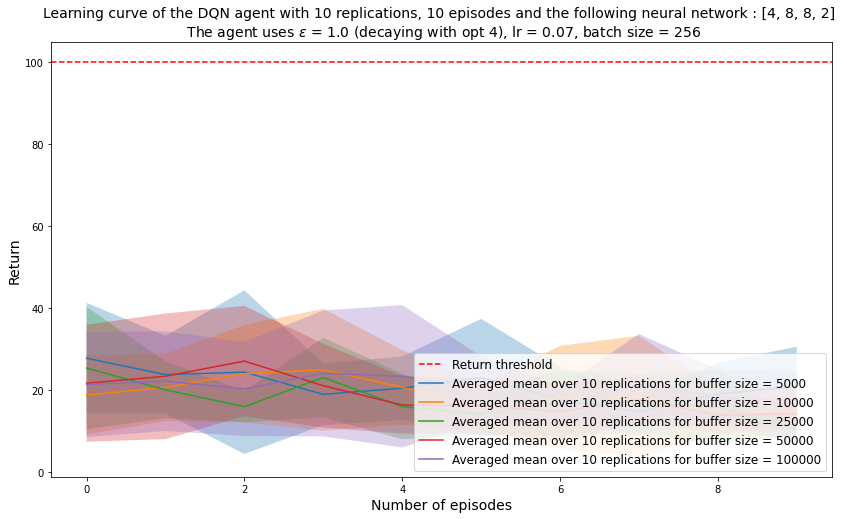

In [28]:
plt.figure(figsize = (14,8))
plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')

for i, buffer in enumerate(buffer_list):
    
    plt.plot(torch.arange(nb_episodes), means_list[i], label = f'Averaged mean over {len(sim_results)} replications for buffer size = {buffer}')
    plt.fill_between(np.arange(nb_episodes), means_list[i]+stds_list[i], means_list[i]-stds_list[i], alpha=0.3)
    plt.title(f"Learning curve of the DQN agent with {len(sim_results)} replications, {nb_episodes} episodes and the following neural network : {DQN_dimensions} \n The agent uses $\epsilon$ = {eps} (decaying with opt {decay_option}), lr = {lr}, batch size = {batch_size}", fontsize = 14)        
    plt.ylabel("Return", fontsize = 14)
    plt.xlabel("Number of episodes", fontsize = 14)
    plt.legend(loc = 'lower right', fontsize = 12)
    
plt.show()

## 5.5 Varying DQN's dimensions (neural network)

#### **Initialization of the parameters**

In [29]:
env = gym.make('CartPole-v1')
nb_episodes = 350
eps = 1.
lr = 0.07
batch_size = 256
buffer_size = 100000
nb_replications = 10
decay_option = 4

dimensions_list = [[4,2], [4, 8, 8, 2], [4, 8, 16, 8, 4, 2], [4, 16, 32, 16, 2]]
dimensions_results = []
means_list = []
stds_list = []

#### **Performing the simulations**

In [30]:
for dim in dimensions_list :   
    
    simulation = Simulation_Decay(env, nb_episodes, dim, eps, lr, batch_size, buffer_size)
    sim_results, policy_trained_DQN, _ = simulation.generate_replications(nb_replications, decay_option)
    results = torch.tensor(sim_results)
    means = results.float().mean(0)
    stds = results.float().std(0)
    means_list.append(means)
    stds_list.append(stds)

Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 208.90it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 88.73it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 250.67it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 169.95it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 257.10it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 278.53it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 217.97it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 227.82it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 238.72it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 154.26it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 150.41it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 157.14it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 131.93it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 97.54it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 133.69it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 141.21it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 173.19it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 25.05it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 102.32it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 20.39it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 78.19it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 79.90it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 113.84it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 102.74it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 111.57it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 94.59it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 93.27it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 128.13it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 129.94it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 132.87it/s]


Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 179.73it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 191.26it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 124.32it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 233.12it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 124.12it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 138.03it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 167.23it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 140.79it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 182.24it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 148.89it/s]


#### **Displaying the results**

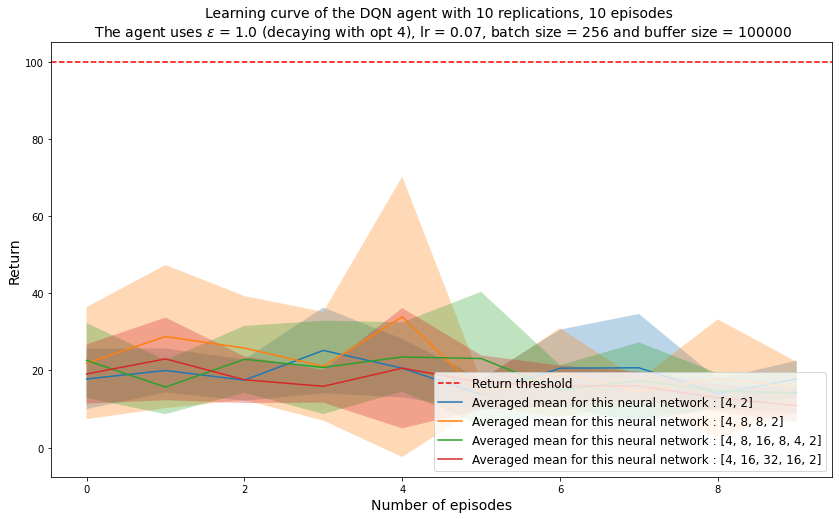

In [31]:
plt.figure(figsize = (14,8))
plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')

for i, dim in enumerate(dimensions_list):
    
    plt.plot(torch.arange(nb_episodes), means_list[i], label = f'Averaged mean for this neural network : {dim}')
    plt.fill_between(np.arange(nb_episodes), means_list[i]+stds_list[i], means_list[i]-stds_list[i], alpha=0.3)
    plt.title(f"Learning curve of the DQN agent with {len(sim_results)} replications, {nb_episodes} episodes \n The agent uses $\epsilon$ = {eps} (decaying with opt {decay_option}), lr = {lr}, batch size = {batch_size} and buffer size = {buffer_size}", fontsize = 14)        
    plt.ylabel("Return", fontsize = 14)
    plt.xlabel("Number of episodes", fontsize = 14)
    plt.legend(loc = 'lower right', fontsize = 12)
    
plt.show()

# 6. Optimal Agent - Learning Curve and Maps

#### **Initialization of the parameters**

In [32]:
env = gym.make('CartPole-v1')
nb_episodes = 350
DQN_dimensions = [4, 8, 8, 2]
eps = 1.
lr = 0.07
batch_size = 256
nb_replications = 2
decay_option = 4
buffer_size = 100000

#### **Performing the simulations**

In [33]:
simulation = Simulation_Decay(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
sim_results, policy_trained_DQN, _ = simulation.generate_replications(nb_replications, decay_option)

Starting replication 1 of 2


100%|██████████| 10/10 [00:00<00:00, 141.23it/s]


Starting replication 2 of 2


100%|██████████| 10/10 [00:00<00:00, 169.94it/s]


#### **Displaying the results**

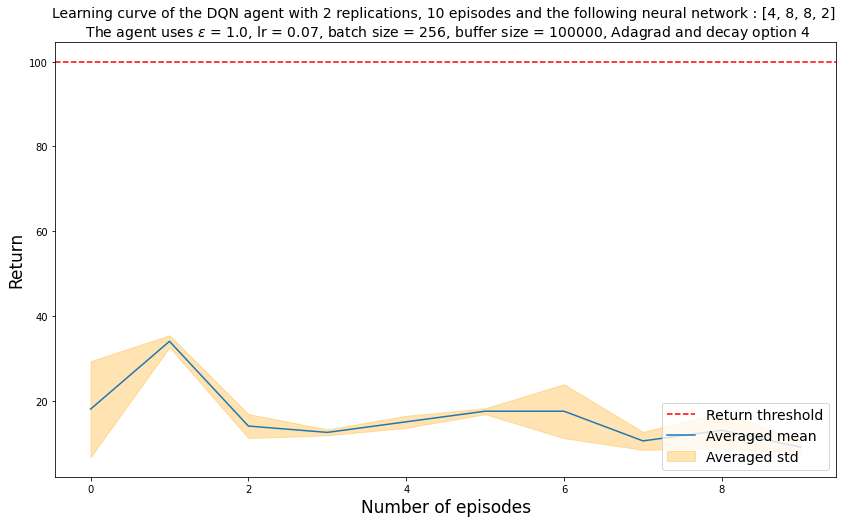

In [34]:
simulation.plot_learning_curve(sim_results)

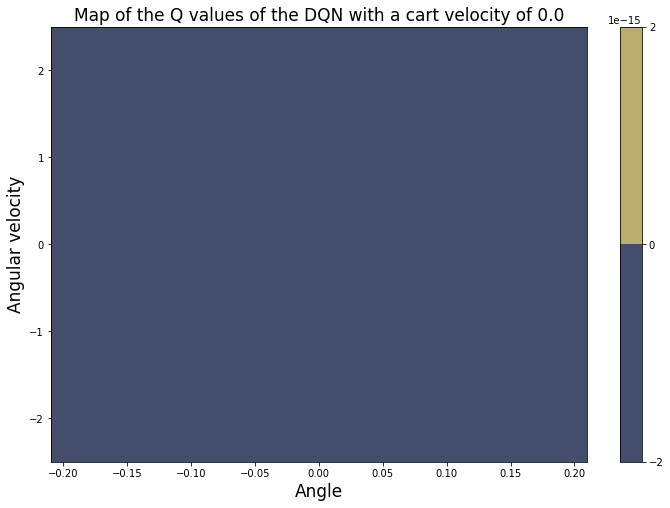

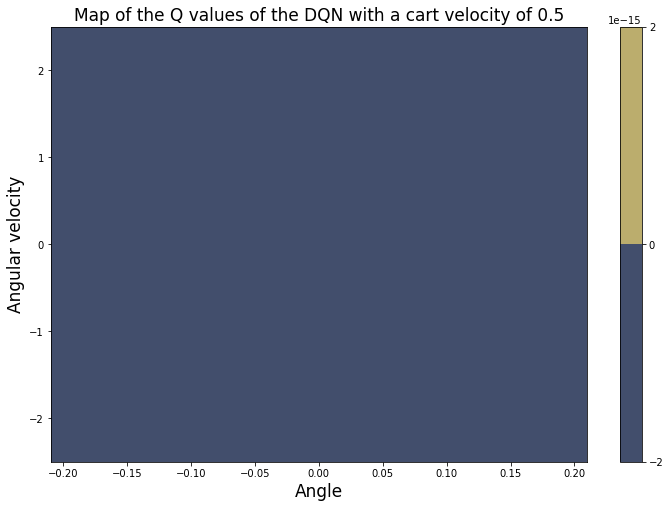

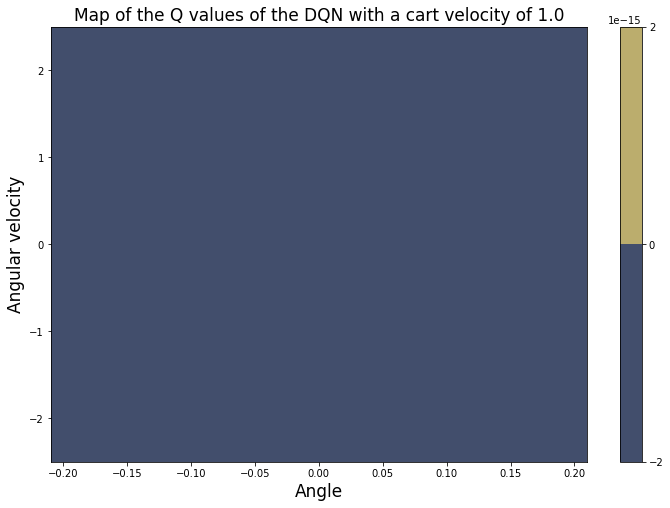

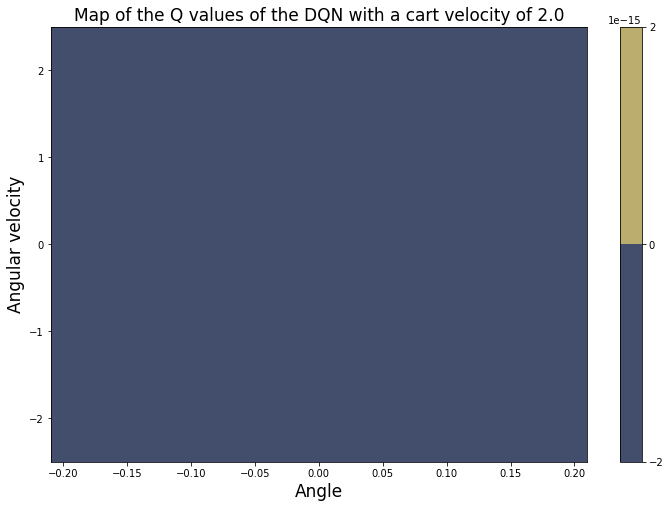

In [35]:
simulation.display_maps(policy_trained_DQN, velocity = 0., q = True)
simulation.display_maps(policy_trained_DQN, velocity = 0.5, q = True)
simulation.display_maps(policy_trained_DQN, velocity = 1., q = True)
simulation.display_maps(policy_trained_DQN, velocity = 2., q = True)

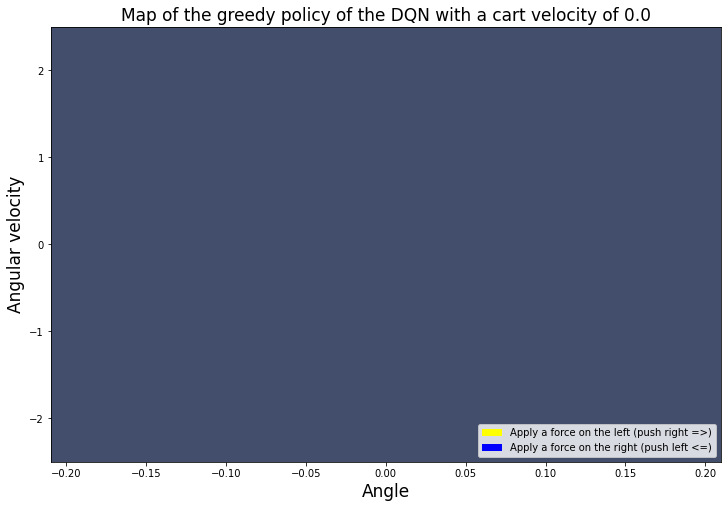

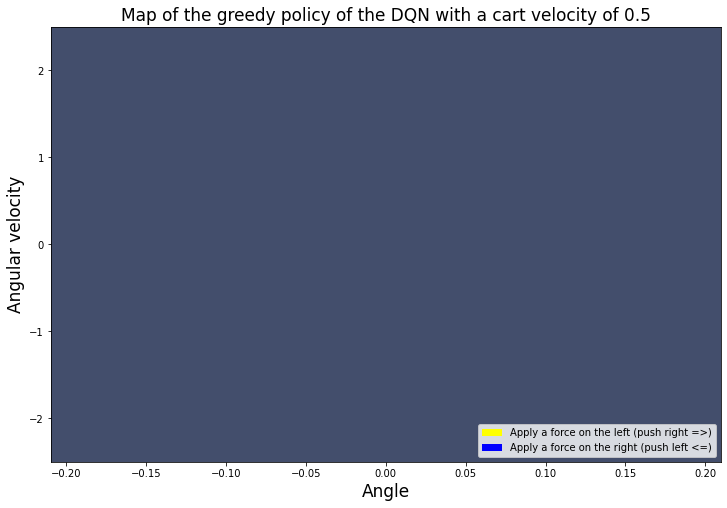

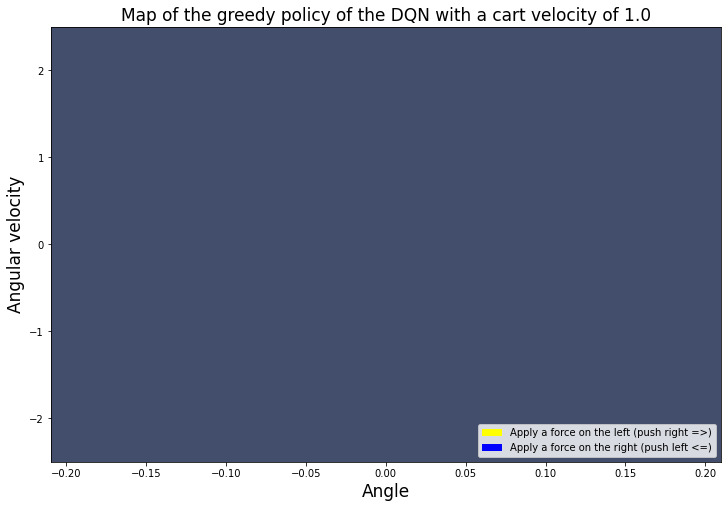

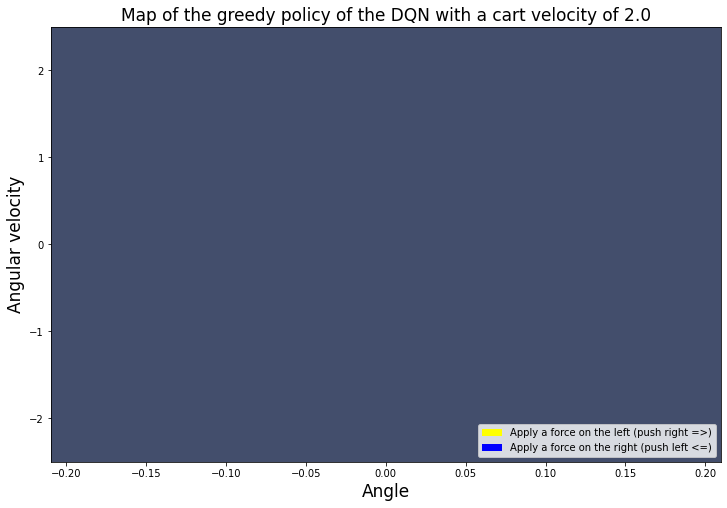

In [36]:
simulation.display_maps(policy_trained_DQN, velocity = 0., q = False)
simulation.display_maps(policy_trained_DQN, velocity = 0.5, q = False)
simulation.display_maps(policy_trained_DQN, velocity = 1., q = False)
simulation.display_maps(policy_trained_DQN, velocity = 2., q = False)

# 7. Turning DQN into DDQN

In [37]:
from utils import loss_DDQN

In [38]:
class Simulation_DDQN():
    
    def __init__(self, env = gym.make('CartPole-v1'), nb_episodes = 300, DQN_dimensions = [4,2], eps = 1., lr = 0.02, batch_size = 1, buffer_size = 1):
        
        #print(eps)
        self.env = env
        self.nb_episodes = nb_episodes
        self.DQN_dimensions = DQN_dimensions
        self.eps = eps
        self.lr = lr
        self.batch_size = batch_size
        self.buffer_size = buffer_size
                
        return
    
    def plot_learning_curve(self, sim_results):
        
        results = torch.tensor(sim_results)
        means = results.float().mean(0)
        stds = results.float().std(0)
        
        plt.figure(figsize = (14,8))
        plt.axhline(y = 100, color = 'r', linestyle = 'dashed', label = 'Return threshold')
        plt.plot(torch.arange(nb_episodes), means, label = f'Averaged mean')
        plt.fill_between(np.arange(nb_episodes), means+stds, means-stds, alpha=0.3, color='orange', label = f'Averaged std')
        plt.title(f"Learning curve of the DDQN agent with {len(sim_results)} replications, {self.nb_episodes} episodes and the following neural network : {self.DQN_dimensions} \n The agent uses $\epsilon$ = {self.eps}, lr = {self.lr}, batch size = {self.batch_size}, buffer size = {self.buffer_size}, Adagrad and decay option 4", fontsize = 14)        
        plt.ylabel("Reward", fontsize = 17)
        plt.xlabel("Number of episodes", fontsize = 17)
        plt.legend(loc = 'lower right', fontsize = 14)
        plt.show()
        
        return
    
    def display_maps(self, policy_net, velocity, q = True):
        
        #policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
        #q = True    # whether q values or greedy policy is visualised

        angle_range = .2095 # you may modify this range
        omega_range = 2.5     # you may modify this range

        angle_samples = 100
        omega_samples = 100
        angles = torch.linspace(angle_range, -angle_range, angle_samples)
        omegas = torch.linspace(-omega_range, omega_range, omega_samples)

        greedy_q_array = torch.zeros((angle_samples, omega_samples))
        policy_array = torch.zeros((angle_samples, omega_samples))
        for i, angle in enumerate(angles):
            for j, omega in enumerate(omegas):
                state = torch.tensor([0., velocity, angle, omega])
                with torch.no_grad():
                    q_vals = policy_net(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, j] = q_vals[greedy_action]
                    policy_array[i, j] = greedy_action
                    
        plt.figure(figsize = (12,8))
        if q:
            plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
            plt.title(f"Map of the Q values of the DDQN with a cart velocity of {velocity}", fontsize = 17)
            plt.colorbar()
            
        else:
            plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
            plt.title(f"Map of the greedy policy of the DDQN with a cart velocity of {velocity}", fontsize = 17)
            leg = [plt.Rectangle((0, 0), 1, 1, fc='yellow'), plt.Rectangle((0, 0), 1, 1, fc='blue')]
            plt.legend(leg, ["Apply a force on the left (push right =>)", "Apply a force on the right (push left <=)"], loc = "lower right")
        
        plt.xlabel("Angle", fontsize = 17)
        plt.ylabel("Angular velocity", fontsize = 17)
        plt.show()
        
        return
    
    def generate_an_episode(self, env, eps, policy_net, memory, batch_size, target_net, optimizer, eps_decay):
        
        #print(eps)
           
        observation, info = self.env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
                
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(eps, policy_net, state)

            observation, reward, done, terminated, info = self.env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size: # HYPERPARAM : 1 = Batch size
                
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss_DDQN(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations = t + 1
                
            t += 1
            
        # Update the target network, copying all weights and biases in DQN
        update_target(target_net, policy_net)  
        
        if eps_decay == 1:
            eps = eps * 0.99
        elif eps_decay == 2:
            eps = eps * 0.97
        elif eps_decay == 3:
            eps = eps * 0.95
        elif eps_decay == 4:
            eps = eps * 0.93
        elif eps_decay == 5:
            eps = eps * 0.9
        else :
            eps = eps * 0.85           
        
        return episode_durations, policy_net, target_net, eps
    
    def genererate_all_episodes(self, nb_episodes, policy_net, memory, target_net, optimizer, eps, eps_decay):
        
        all_durations = []  
        all_eps = []
        
        #all_eps.append(eps)
        
        for episode in tqdm.tqdm(range(nb_episodes)):
            
            all_eps.append(eps)
            ep_duration, policy_net, target_net, eps = self.generate_an_episode(env, eps, policy_net, memory, batch_size, target_net, optimizer, eps_decay)
            #print(eps)
            all_durations.append(ep_duration)
            
            
        return all_durations, all_eps
    
    def generate_replications(self, nb_replications, eps_decay):
        
        all_results = []
        all_eps_decay = []
        
        for replicate in range(nb_replications):
            
            print(f"Starting replication {replicate+1} of {nb_replications}")
            policy_net = DQN(self.DQN_dimensions)
            target_net = DQN(self.DQN_dimensions)
            update_target(target_net, policy_net)
            target_net.eval()

            #optimizer = optim.SGD(policy_net.parameters(), lr) 
            #optimizer = optim.Adam(policy_net.parameters(), lr)
            optimizer = optim.Adagrad(policy_net.parameters(), lr)
            memory = ReplayBuffer(buffer_size)
            
            all_ep_durations, all_eps_values = self.genererate_all_episodes(nb_episodes, policy_net, memory, target_net, optimizer, eps, eps_decay)
            all_results.append(all_ep_durations)
            all_eps_decay.append(all_eps_values)
        
        return all_results, policy_net, all_eps_decay

In [39]:
env = gym.make('CartPole-v1')
nb_episodes = 350
DQN_dimensions = [4, 8, 8, 2]
eps = 1.
lr = 0.07
batch_size = 256
nb_replications = 10
decay_option = 4
buffer_size = 100000

In [40]:
simulation = Simulation_Decay(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
sim_results, policy_trained_DQN, _ = simulation.generate_replications(nb_replications, decay_option)

Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 115.25it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 151.92it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 172.55it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 194.33it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 186.06it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 125.33it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 144.43it/s]


Starting replication 8 of 10


100%|██████████| 10/10 [00:00<00:00, 196.61it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 159.15it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 145.32it/s]


In [41]:
simulation_DDQN = Simulation_DDQN(env, nb_episodes, DQN_dimensions, eps, lr, batch_size, buffer_size)
sim_results_DDQN, policy_trained_DDQN, _ = simulation_DDQN.generate_replications(nb_replications, decay_option)

Starting replication 1 of 10


100%|██████████| 10/10 [00:00<00:00, 53.48it/s]


Starting replication 2 of 10


100%|██████████| 10/10 [00:00<00:00, 122.30it/s]


Starting replication 3 of 10


100%|██████████| 10/10 [00:00<00:00, 123.79it/s]


Starting replication 4 of 10


100%|██████████| 10/10 [00:00<00:00, 151.88it/s]


Starting replication 5 of 10


100%|██████████| 10/10 [00:00<00:00, 130.62it/s]


Starting replication 6 of 10


100%|██████████| 10/10 [00:00<00:00, 143.19it/s]


Starting replication 7 of 10


100%|██████████| 10/10 [00:00<00:00, 137.25it/s]

Starting replication 8 of 10



100%|██████████| 10/10 [00:00<00:00, 135.50it/s]


Starting replication 9 of 10


100%|██████████| 10/10 [00:00<00:00, 136.17it/s]


Starting replication 10 of 10


100%|██████████| 10/10 [00:00<00:00, 151.94it/s]


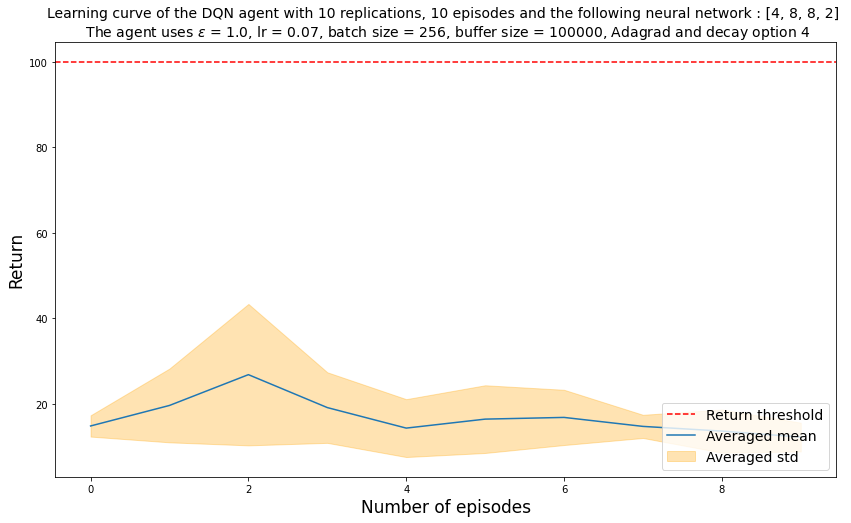

In [42]:
simulation.plot_learning_curve(sim_results)

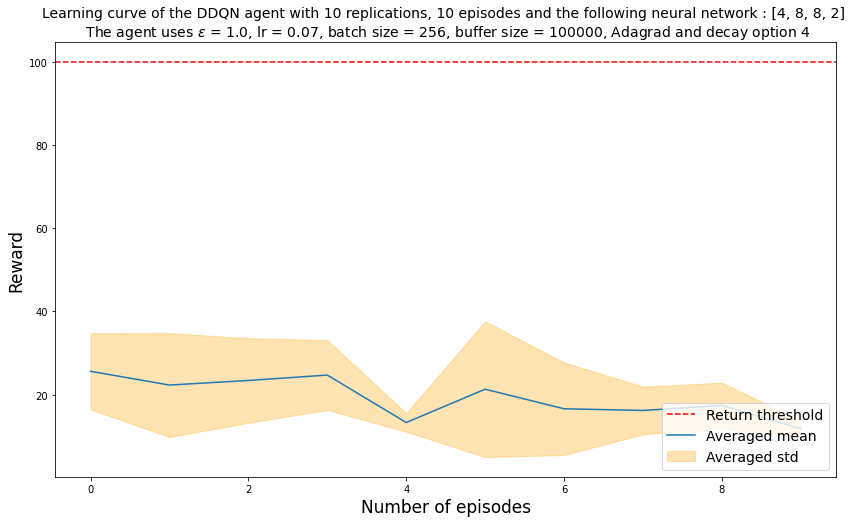

In [43]:
simulation_DDQN.plot_learning_curve(sim_results_DDQN)